## Import Requirements

In [1]:
from pathlib import Path
from copy import copy
from matplotlib import pyplot as plt

import numpy as np
from scipy import optimize

from absorptive_experiment_misc.definitions import *

from src.kernel.event import Event
from src.kernel.process import Process
from src.kernel.timeline import Timeline
from src.kernel.quantum_manager import KET_STATE_FORMALISM, DENSITY_MATRIX_FORMALISM

## Simulation Setup

In [2]:
# Working simulation setup

params = {
    "QUANTUM_WAVELENGTH" : 1536.,  # wavelength of AFC memory resonant absorption, of SPDC source signal photon
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.5,  # mean photon number of SPDC source on node 1

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.5, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.5,  # efficiency of detector 2 of BSM
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 20.,
    "SIGNAL_DET_DEAD" : 5000,
    "IDLER_DET_DEAD" : 5000,

    # fibers
    "SIGNAL_DIST" : 10.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 10.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.076  * 10/np.log(10),  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,
    'POLARIZATION_FIDELITY': 0.5,

    # experiment settings
    "num_bs_trials_per_phase" : 1,
    "phase_settings" : (np.linspace(0, 2*np.pi, num=50, endpoint=False)),

    "MODE_NUM": 8000,
}

timeline = Timeline(1e12, formalism=DENSITY_MATRIX_FORMALISM)



In [3]:
# Experimental simulation setup

params = {
    "QUANTUM_WAVELENGTH" : 1536.,  # wavelength of AFC memory resonant absorption, of SPDC source signal photon
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.5,  # mean photon number of SPDC source on node 1

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.5, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.5,  # efficiency of detector 2 of BSM
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 20.,
    "SIGNAL_DET_DEAD" : 5000,
    "IDLER_DET_DEAD" : 5000,

    # fibers
    "SIGNAL_DIST" : 1.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 1.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.076  * 10/np.log(10),  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,
    'POLARIZATION_FIDELITY': 0.3,

    # experiment settings
    "num_bs_trials_per_phase" : 1,
    "phase_settings" : (np.linspace(0, 2*np.pi, num=13, endpoint=False)),

    "MODE_NUM": 100,
}

timeline = Timeline(1e12, formalism=DENSITY_MATRIX_FORMALISM)



## Network Setup

In [4]:
signal_receiver_name = "signal_receiver"
idler_receiver_name = "idler_receiver"
signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

source_node_name = "Polariation_source_node"
source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

projector:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
rx:

[[ 1.  0.]
 [-0.  1.]]
projector:
[[1. 0.]
 [0. 0.]]
rx:

[[ 1.  0.]
 [-0.  1.]]


## Run simulation and data acquisition

# Working Run code
coincidences = []
idler_singles = []
signal_singles = []

for idler_phase in [0, np.pi/2, np.pi, 3*np.pi/2]:
    print("\nNew Idler phase:", idler_phase)
    signal_receiver.reset()
    signal_receiver.rotateIdler(idler_phase)
    for signal_phase in params["phase_settings"]:
        timeline.init()
        print("New Signal phase:", signal_phase)
        signal_receiver.rotateSignal(signal_phase)

        for j in range(params["num_bs_trials_per_phase"]):
            source_node.start()
            timeline.run()

    new_signal_singles, new_idler_singles, new_coincidences = signal_receiver.get_data()
    signal_singles.append(new_signal_singles)
    idler_singles.append(new_idler_singles)
    coincidences.append(new_coincidences)


In [5]:
from multiprocessing import Process
from json import dump
# Experimental Run code
coincidences = []
idler_singles = []
signal_singles = []

def run_simulations(idler_phase):
    print("\nNew Idler phase:", idler_phase)
    signal_receiver.reset()
    signal_receiver.rotateIdler(idler_phase)
    for signal_phase in params["phase_settings"]:
        timeline.init()
        print("New Signal phase:", signal_phase, "(Idler:", idler_phase, ")")
        signal_receiver.rotateSignal(signal_phase)

        source_node.start()
        timeline.run()

    new_signal_singles, new_idler_singles, new_coincidences = signal_receiver.get_data()
    # signal_singles.append(new_signal_singles)
    # idler_singles.append(new_idler_singles)
    # coincidences.append(new_coincidences)
    out_dict = {"signal":new_signal_singles, "idler":new_idler_singles, "coincidence":new_coincidences}
    f = open(f"results/polarization/first/outdata{idler_phase}.json", "w")
    dump(out_dict, f)

for idler_phase in [0, np.pi/2, np.pi, 3*np.pi/2]:
    p = Process( target=run_simulations, args=(idler_phase,) )
    p.start()
    p.join()
    



New Idler phase: 0
New Signal phase: 0.0 (Idler: 0 )
incoming photons:
Keys:
[]
State:
[[ 0.31030952+0.j  0.        +0.j  0.        +0.j  0.22011575+0.j]
 [ 0.        +0.j -0.        +0.j  0.09019377+0.j  0.        +0.j]
 [ 0.        +0.j  0.09019377+0.j -0.        +0.j  0.        +0.j]
 [ 0.22011575+0.j  0.        +0.j  0.        +0.j  0.31030952+0.j]]
Keys:
[]
State:
[[ 0.31030952+0.j  0.        +0.j  0.        +0.j  0.22011575+0.j]
 [ 0.        +0.j -0.        +0.j  0.09019377+0.j  0.        +0.j]
 [ 0.        +0.j  0.09019377+0.j -0.        +0.j  0.        +0.j]
 [ 0.22011575+0.j  0.        +0.j  0.        +0.j  0.31030952+0.j]]
rotating 2 qubits:
projector:
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
rx:

[[ 1.  0.]
 [-0.  1.]]

[[ 1.  0.]
 [-0.  1.]]
incoming photons:
Keys:
[]
State:
[[ 0.31030952+0.j  0.        +0.j  0.        +0.j  0.22011575+0.j]
 [ 0.        +0.j -0.        +0.j  0.09019377+0.j  0.        +0.j]
 [ 0.        +0.j  0.09019377+0.j -0.        +0


projector:
[[1. 0.]
 [0. 0.]]
rx:

[[ 1.  0.]
 [-0.  1.]]
det_idler_max_singles_prob: (0.33481235461957676+0j) det_signal_max_singles_prob (0.33481235461957676+0j)
det_idler_remaining_prob 0.03552729635267355 det_signal_remaining_prob 0.03552729635267355
incoming photons:
Keys:
[]
State:
[[ 0.31030952+0.j  0.        +0.j  0.        +0.j  0.22011575+0.j]
 [ 0.        +0.j -0.        +0.j  0.09019377+0.j  0.        +0.j]
 [ 0.        +0.j  0.09019377+0.j -0.        +0.j  0.        +0.j]
 [ 0.22011575+0.j  0.        +0.j  0.        +0.j  0.31030952+0.j]]
Keys:
[]
State:
[[ 0.31030952+0.j  0.        +0.j  0.        +0.j  0.22011575+0.j]
 [ 0.        +0.j -0.        +0.j  0.09019377+0.j  0.        +0.j]
 [ 0.        +0.j  0.09019377+0.j -0.        +0.j  0.        +0.j]
 [ 0.22011575+0.j  0.        +0.j  0.        +0.j  0.31030952+0.j]]
rotating 2 qubits:
projector:
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
rx:

[[ 1.  0.]
 [-0.  1.]]

[[ 1.  0.]
 [-0.  1.]]
single polari

## Data representation

# Working data representation

def sinusoid(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

fringe_domain = params["phase_settings"]

params0, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[0], p0=(80,1,1,1))
params1, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[1], p0=(80,1,1,1))
params2, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[2], p0=(80,1,1,1))
params3, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[3], p0=(80,1,1,1))


plt.figure(figsize=(15,4))
plt.ylim([0, max(max(coincidences))])
plt.plot(fringe_domain, coincidences[0], 'bo')
plt.plot(fringe_domain, coincidences[1], 'ko')
plt.plot(fringe_domain, coincidences[2], 'mo')
plt.plot(fringe_domain, coincidences[3], 'ro')

plt.plot(fringe_domain, sinusoid(fringe_domain, *params0), 'b',  label = "Hvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params1), 'k',  label = "Dvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params2), 'm',  label = "Vvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params3), 'r',  label = "Avis", linewidth = 3)

plt.title("Coincidences")
plt.legend()
plt.xlabel('Phase angle')
plt.ylabel('Number of coincidences')


plt.figure()
plt.ylim([0, max(max(signal_singles))])
plt.plot(fringe_domain, signal_singles[0], 'bx', label = "Hvis")
plt.plot(fringe_domain, signal_singles[1], 'kx', label = "Dvis")
plt.plot(fringe_domain, signal_singles[2], 'mx', label = "Vvis")
plt.plot(fringe_domain, signal_singles[3], 'rx', label = "Avis")
plt.title("Signal detector singles counts")
plt.legend()


plt.figure()
plt.ylim([0, max(max(idler_singles))])
plt.plot(fringe_domain, idler_singles[0], 'bx', label = "Hvis")
plt.plot(fringe_domain, idler_singles[1], 'kx', label = "Dvis")
plt.plot(fringe_domain, idler_singles[2], 'mx', label = "Vvis")
plt.plot(fringe_domain, idler_singles[3], 'rx', label = "Avis")
plt.title("Idler detector singles counts")
plt.legend()

plt.show()

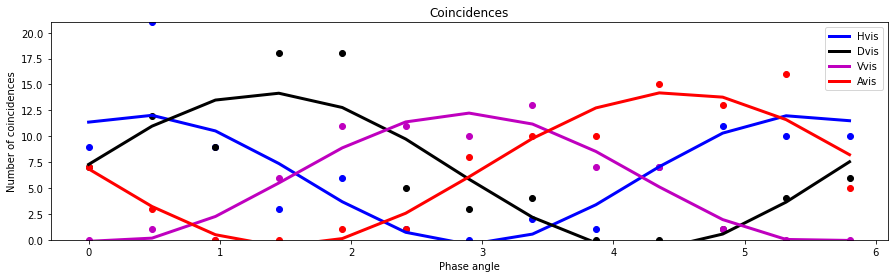

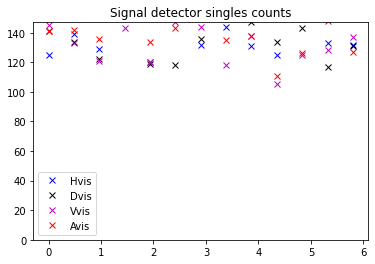

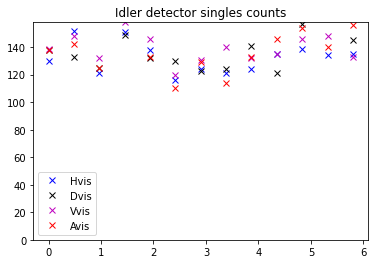

In [ ]:
from json import load
coincidences = []
signal_singles = []
idler_singles = []

for idler_phase in [0, np.pi/2, np.pi, 3*np.pi/2]:
    f = open(f"results/polarization/first/outdata{idler_phase}.json", 'r')
    data = load(f)
    coincidences.append(data["coincidence"])
    signal_singles.append(data["signal"])
    idler_singles.append(data["idler"])

def sinusoid(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

fringe_domain = params["phase_settings"]

params0, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[0], p0=(80,1,1,1))
params1, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[1], p0=(80,1,1,1))
params2, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[2], p0=(80,1,1,1))
params3, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[3], p0=(80,1,1,1))


plt.figure(figsize=(15,4))
plt.ylim([0, max(max(coincidences))])
plt.plot(fringe_domain, coincidences[0], 'bo')
plt.plot(fringe_domain, coincidences[1], 'ko')
plt.plot(fringe_domain, coincidences[2], 'mo')
plt.plot(fringe_domain, coincidences[3], 'ro')

plt.plot(fringe_domain, sinusoid(fringe_domain, *params0), 'b',  label = "Hvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params1), 'k',  label = "Dvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params2), 'm',  label = "Vvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params3), 'r',  label = "Avis", linewidth = 3)

plt.title("Coincidences")
plt.legend()
plt.xlabel('Phase angle')
plt.ylabel('Number of coincidences')


plt.figure()
plt.ylim([0, max(max(signal_singles))])
plt.plot(fringe_domain, signal_singles[0], 'bx', label = "Hvis")
plt.plot(fringe_domain, signal_singles[1], 'kx', label = "Dvis")
plt.plot(fringe_domain, signal_singles[2], 'mx', label = "Vvis")
plt.plot(fringe_domain, signal_singles[3], 'rx', label = "Avis")
plt.title("Signal detector singles counts")
plt.legend()


plt.figure()
plt.ylim([0, max(max(idler_singles))])
plt.plot(fringe_domain, idler_singles[0], 'bx', label = "Hvis")
plt.plot(fringe_domain, idler_singles[1], 'kx', label = "Dvis")
plt.plot(fringe_domain, idler_singles[2], 'mx', label = "Vvis")
plt.plot(fringe_domain, idler_singles[3], 'rx', label = "Avis")
plt.title("Idler detector singles counts")
plt.legend()

plt.show()

In [ ]:
from multiprocessing import Process

def func(arg):
    print(arg*2)

args = [1,2,3]


# proesses = [Process( target=func, args=(args[i],) ) for i in range(3)]
for i in range(3):
    p = Process( target=func, args=(args[i],) )
    p.start()
    p.join()

2
4
6


iter: 0 mpn: 0.025
signal_detections: [[4900001, 5010022, 5090038, 5120044, 5130046, 5190058, 5220064, 5290079, 5310083, 5340089, 5350090, 5400100, 5410102, 5480116, 5530127, 5640148, 5710163, 5740168, 5800182, 5820185, 5880197, 5910204, 6000222, 6020225, 6070235, 6080237, 6110243, 6210264, 6250271, 6300281, 6310283, 6330287, 6340289, 6370296, 6390299, 6440310, 6600342, 6620345, 6690360, 6710363, 6740369, 6780377, 6850391, 6890399, 6910403, 6960414, 7030428, 7090440, 7130448, 7200462, 7250472, 7400501, 7410504, 7420505, 7460514, 7470515, 7490519, 7510523, 7530528, 7570536, 7670557, 7730568, 7790580, 7930608, 8010624, 8050632, 8110644, 8190661, 8240671, 8330689, 8350694, 8400703, 8440711, 8470718, 8520728, 8540732, 8560736, 8640751, 8660756, 8670757, 8690761, 8790781, 8800783, 8810786, 8820787, 8960816, 8970817, 8990822, 9000823, 9050833, 9110845, 9180860, 9320888, 9330890, 9340891, 9350894, 9460915, 9580940, 9640952, 9710965, 9730969, 9800984, 9840991, 9870998, 9881000, 9891001, 996101

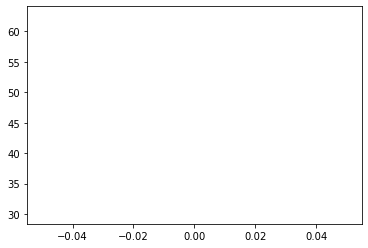

In [9]:
# Testing out validation code in python notebook
## IMPORT REQUIREMENTS

from matplotlib import pyplot as plt
import numpy as np
from scipy import optimize
from multiprocessing import Process
from json import dump

from absorptive_experiment_misc.definitions import *
from src.kernel.timeline import Timeline
from src.kernel.quantum_manager import DENSITY_MATRIX_FORMALISM

np.random.seed = 12321

## SIMULATION SETUP
# visibility at fringe bottom: .01 * .01 * .25/4
params = {
    "QUANTUM_WAVELENGTH" : 1536.,
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.02,  # mean photon number of SPDC source on node 1
    "MPN_SETTINGS": [0.025],

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.2, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.2,  # efficiency of detector 2 of BSM
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 1,
    "SIGNAL_DET_DEAD" : 2000,
    "IDLER_DET_DEAD" : 2000,

    # fibers
    "SIGNAL_DIST" : 1.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 1.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.,  # attenuation rate of optical fibre (in dB/km)
    'POLARIZATION_FIDELITY': 0.,

    # experiment settings
    "num_bs_trials_per_phase" : 1,
    "phase_settings" : [np.pi],

    "MODE_NUM": 10000000,

}

coincidences = []
idler_singles = []
signal_singles = []

def run_simulations(idler_phase):
    # print("\nNew Idler phase:", idler_phase)
    signal_receiver.reset()
    signal_receiver.rotateIdler(idler_phase)
    for signal_phase in params["phase_settings"]:
        timeline.init()
        # print("New Signal phase:", signal_phase, "(Idler:", idler_phase, ")")
        signal_receiver.rotateSignal(signal_phase)
        source_node.start()
        timeline.run()

    new_signal_singles, new_idler_singles, new_coincidences = signal_receiver.get_data()
    # return new_coincidences[0], new_coincidences[1]
    return new_coincidences[0]


# coinc_fringe_top = []
coinc_fringe_bottom = []

for mpn in params["MPN_SETTINGS"]:
    
    timeline = Timeline(2e12, formalism=DENSITY_MATRIX_FORMALISM)


    ## NETWORK SETUP

    signal_receiver_name = "signal_receiver"
    idler_receiver_name = "idler_receiver"
    signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
    idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

    source_node_name = "Polariation_source_node"
    source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

    qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
    qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

    source_node.set_source_mpn(mpn)
    coinc_fringe_bottom_sum = 0
    local_singles_a = 0
    local_singles_b = 0
    for iter in range(1):
        print("iter:", iter, "mpn:", mpn)
        coinc_fringe_bottom_sum += run_simulations(idler_phase=0)
        print("singles_a sum:", signal_receiver.singles_a, "singles_b sum:", signal_receiver.singles_b, "rejects:", signal_receiver.rejects)
        local_singles_a += signal_receiver.singles_a
        local_singles_b += signal_receiver.singles_b
        signal_receiver.rejects = 0
        signal_receiver.singles_a = 0
        signal_receiver.singles_b = 0
    print("avg local_singles_a:", local_singles_a/1, "avg local_singles_b:", local_singles_b/100, )
    # coinc_fringe_top_trial, coinc_fringe_bottom_trial = run_simulations(idler_phase=0)
    # coinc_fringe_top.append(coinc_fringe_top_trial)
    coinc_fringe_bottom.append(coinc_fringe_bottom_sum/1)
    print("fringe bottom:", coinc_fringe_bottom_sum/1, "expected bottom:", params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn**2)/4)

exp_coinc_fringe_top = [params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn/2 + (mpn**2)/4) for mpn in params["MPN_SETTINGS"]]
exp_coinc_fringe_bottom = [params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn**2)/4 for mpn in params["MPN_SETTINGS"]]

# plt.figure()
# plt.plot(coinc_fringe_top)
# plt.plot(exp_coinc_fringe_top)

plt.figure()
plt.plot([i for i in coinc_fringe_bottom])
plt.plot(exp_coinc_fringe_bottom)


print("coinc_fringe_bottom:", [i for i in coinc_fringe_bottom])
print("exp_coinc_fringe_top:", exp_coinc_fringe_bottom)



# print("actual fringe top:", coinc_fringe_top, "actual fringe bottom:", coinc_fringe_bottom)
# print("expected fringe top:", exp_coinc_fringe_top, "expected fringe bottom:", exp_coinc_fringe_bottom)

# print("error in finge top:", abs(exp_coinc_fringe_top-coinc_fringe_top)/exp_coinc_fringe_top)
# print("error in finge bottom:", abs(exp_coinc_fringe_bottom-coinc_fringe_bottom)/exp_coinc_fringe_bottom)

# processes = [Process( target=run_simulations, args=(idler_phase,) ) for idler_phase in [0]]
# for p in processes:
#     p.start()

# for p in processes:
#     p.join()
    

coinc_fringe_bottom: [30.0]
exp_coinc_fringe_top: [31.25000000000001]


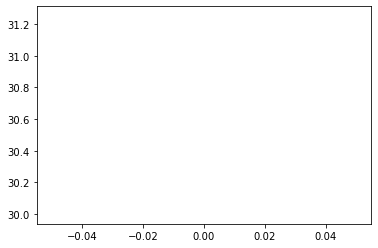

In [6]:
plt.figure()
plt.plot([2*i for i in coinc_fringe_bottom])
plt.plot(exp_coinc_fringe_bottom)


print("coinc_fringe_bottom:", [2*i for i in coinc_fringe_bottom])
print("exp_coinc_fringe_top:", exp_coinc_fringe_bottom)

In [8]:
coincidence_count = 0
signal_detections = [[130, 150,250,300,350]]
idler_detections = [[99,110,123,125,136,151,200,248,302,350]]
temporal_coincidence_window = 5

for signal, idler in zip(signal_detections, idler_detections):
    coincidence_count = 0
    idler_index = 0
    for i in signal:
        while idler_index < len(idler) and idler[idler_index] < i-temporal_coincidence_window:
            idler_index += 1
        if idler_index >= len(idler):
            break
        elif abs(i-idler[idler_index]) <= temporal_coincidence_window:
            coincidence_count += 1
coincidence_count

5

coinc_fringe_bottom: [3.0, 4.5, 6.0, 7.5]
exp_coinc_fringe_top: [12.250000000000004, 16.000000000000004, 20.250000000000004, 25.00000000000001]


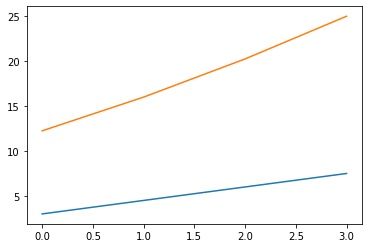

In [ ]:
exp_coinc_fringe_top = [params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn/2 + (mpn**2)/4) for mpn in params["MPN_SETTINGS"]]
exp_coinc_fringe_bottom = [params["MODE_NUM"] * (params["SIGNAL_DET_EFFICIENCY"]**2)*(mpn**2)/4 for mpn in params["MPN_SETTINGS"]]

# plt.figure()
# plt.plot(coinc_fringe_top)
# plt.plot(exp_coinc_fringe_top)

# print("coinc_fringe_top:", coinc_fringe_top)
# print("exp_coinc_fringe_top:", exp_coinc_fringe_top)

plt.figure()
plt.plot([i for i in coinc_fringe_bottom])
plt.plot(exp_coinc_fringe_bottom)

print("coinc_fringe_bottom:", [i for i in coinc_fringe_bottom])
print("exp_coinc_fringe_top:", exp_coinc_fringe_bottom)


# OBSOLETE SETUP CODE

from typing import List, Tuple
from math import sqrt
from matplotlib import pyplot as plt
from pprint import pprint

import numpy as np
from src.kernel.quantum_state import FreeQuantumState
from src.kernel.timeline import Timeline
from src.components.polarizer import Polarizer

detector0_singles_count = 0
detector1_singles_count = 0
coincidence_count = 0
  
detector0_singles = []
detector1_singles = []
coincidence = []
singled_coincidences = []

default_rng = np.random.default_rng()

two_qubit_basis = ((
                (complex(1), complex(0), complex(0), complex(0)),
                (complex(0), complex(1), complex(0), complex(0)),
                (complex(0), complex(0), complex(1), complex(0)),
                (complex(0), complex(0), complex(0), complex(1))
            ))
one_qubit_basis = (
                        (complex(0), complex(1)),
                        (complex(1), complex(0))
                  )   

# OBSOLETE DEFINITION CODE

tl = Timeline(1e12)
pol = Polarizer("Polarizer", tl, num_qubits=2)
pol_single_qubit = Polarizer("single_qubit_Polarizer", tl, num_qubits=1)

def _generate_tmsv_state(mean_photon_num, truncation):
    """Method to generate two-mode squeezed vacuum state of two output photonic modes

    Returns:
        array: generated state.
    """

    mean_num = mean_photon_num
    truncation = truncation

    # print("truncation is:", truncation)

    # create state component amplitudes list
    amp_list = [(sqrt(mean_num / (mean_num + 1)) ** m) / sqrt(mean_num + 1) for m in range(truncation)]
    amp_square_list = [amp ** 2 for amp in amp_list]
    amp_list.append(sqrt(1 - sum(amp_square_list)))

    # create two-mode state vector
    state_vec = np.zeros((truncation+1) ** 2)

    for i in range(truncation+1):
        amp = amp_list[i]
        basis = np.zeros(truncation+1)
        basis[i] = 1
        basis = np.kron(basis,basis)
        state_vec += amp * basis

    return state_vec

# OBSOLETE DIRECT EXECUTION RESULTS

fringe_domain = np.linspace(0, 2*np.pi, num = 50)
max_iter = 1000

# fringe_domain = [np.pi/8]
# max_iter = 1

# original_state = (0.5*complex(1/sqrt(2)), complex(0), complex(0), 0.5*complex(1/sqrt(2)))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)

for theta in fringe_domain:
    print("theta:", theta)
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    singled_coincidences_count = 0
    for iter in range(max_iter):        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # print("entangkled states:", bell_state[0].state, bell_state[1].state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
            pass # We had coincidence. Send the detection event to both the detectors.
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:np.pi})
            pol_single_qubit.get(bell_state[1])

            # print("quantum state 0:\n", bell_state[0].state)
            # print("quantum state 1:\n", bell_state[1].state)
            
            # detect0_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob=True)
            # detect1_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob=True)

            if not bell_state[0].measure(one_qubit_basis, default_rng):
                detector0_singles_count += 1
                pass # send measurment signal to detector0

            if not bell_state[1].measure(one_qubit_basis, default_rng):
                detector1_singles_count += 1
                pass # send measurment signal to detector1
    coincidence.append(coincidence_count)
    detector0_singles.append(detector0_singles_count + 0.5*coincidence_count)
    detector1_singles.append(detector1_singles_count + 0.5*coincidence_count)
                
                
    # coincidence.append(coincidence_count)
    # detector0_singles.append(detector0_singles_count + coincidence_count)
    # detector1_singles.append(detector1_singles_count + coincidence_count)
    # singled_coincidences.append(singled_coincidences_count)
        
# ylim = max(max(coincidence, detector0_singles, detector1_singles))
plt.figure()
plt.plot(fringe_domain, coincidence)
plt.title("Coincidences")
plt.ylim([0, max(coincidence)])
# plt.figure()
# plt.plot(fringe_domain, singled_coincidences)
# plt.title("Singled coincidences")
# plt.ylim([0, max(singled_coincidences)])
plt.figure()
plt.plot(fringe_domain, detector0_singles)
plt.title("Detector 0 singles counts")
plt.ylim([0, max(detector0_singles)])
plt.figure()
plt.plot(fringe_domain, detector1_singles)
plt.title("Detector 1 singles counts")
plt.ylim([0, max(detector1_singles)])
coincidence = []
detector0_singles = []
detector1_singles = []

# OBSOLETE DIRECT EXECUTION RESULTS

fringe_domain = np.linspace(0, 2*np.pi, num = 50)
max_iter = 1000

# fringe_domain = [np.pi/8]
# max_iter = 1

# original_state = (0.5*complex(1/sqrt(2)), complex(0), complex(0), 0.5*complex(1/sqrt(2)))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)

for theta in fringe_domain:
    print("theta:", theta)
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    singled_coincidences_count = 0
    for iter in range(max_iter):        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # print("entangkled states:", bell_state[0].state, bell_state[1].state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        # states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)

        # if default_rng.random() < probabilities[-1]: # Checking the coincidence probability in the VV basis. 
        #     coincidence_count += 1
        #     pass # We had coincidence. Send the detection event to both the detectors.
        # else:


        bell_state[0].set_state(original_state)
        bell_state[0].split_states()

        pol_single_qubit.rotate({0:theta})
        pol_single_qubit.get(bell_state[0])

        pol_single_qubit.rotate({0:np.pi})
        pol_single_qubit.get(bell_state[1])

        # print("quantum state 0:\n", bell_state[0].state)
        # print("quantum state 1:\n", bell_state[1].state)
        
        detect0_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob=True)
        detect1_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob=True)

        # if np.random.rand() < detect0_prob:
        #     detector0_singles_count += 1
        # if np.random.rand() < detect1_prob:
        #     detector1_singles_count += 1

        if np.random.rand() < detect0_prob:
            detector0_result = 1
        else:
            detector0_result = 0
        
        if np.random.rand() < detect1_prob:
            detector1_result = 1
        else:
            detector1_result = 0
                
            # if not detector0_result and detector1_result:
            #     detector0_singles_count += detector0_result
            #     detector1_singles_count += detector1_result
            #     break
            

    coincidence.append(coincidence_count)
    detector0_singles.append(detector0_singles_count)
    detector1_singles.append(detector1_singles_count)
                
                
    # coincidence.append(coincidence_count)
    # detector0_singles.append(detector0_singles_count + coincidence_count)
    # detector1_singles.append(detector1_singles_count + coincidence_count)
    # singled_coincidences.append(singled_coincidences_count)
        
# ylim = max(max(coincidence, detector0_singles, detector1_singles))
plt.figure()
plt.plot(fringe_domain, coincidence)
plt.title("Coincidences")
plt.ylim([0, max(coincidence)])
# plt.figure()
# plt.plot(fringe_domain, singled_coincidences)
# plt.title("Singled coincidences")
# plt.ylim([0, max(singled_coincidences)])
plt.figure()
plt.plot(fringe_domain, detector0_singles)
plt.title("Detector 0 singles counts")
plt.ylim([0, max(detector0_singles)])
plt.figure()
plt.plot(fringe_domain, detector1_singles)
plt.title("Detector 1 singles counts")
plt.ylim([0, max(detector1_singles)])
coincidence = []
detector0_singles = []
detector1_singles = []

# OBSOLETE DIRECT EXECUTION RESULTS

fringe_domain = np.linspace(0, 2*np.pi, num = 50)
original_state = (complex(np.sqrt(3)/2), complex(0), complex(0), complex(0.5))
# original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)

# fringe_domain = [np.pi/3]
for theta in fringe_domain:
    print("theta:", theta)
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(10000):        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # print("entangkled states:", bell_state[0].state, bell_state[1].state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
            pass # We had coincidence. Send the detection event to both the detectors.
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:np.pi})
            pol_single_qubit.get(bell_state[1])
            
            if not bell_state[0].measure(one_qubit_basis, default_rng):
                detector0_singles_count += 1
                pass # send measurment signal to detector0

            if not bell_state[1].measure(one_qubit_basis, default_rng):
                detector1_singles_count += 1
                pass # send measurment signal to detector1
    coincidence.append(coincidence_count)
    detector0_singles.append(detector0_singles_count)
    detector1_singles.append(detector1_singles_count)
        
plt.figure()
plt.plot(fringe_domain, coincidence)
plt.title("Coincidences")
plt.figure()
plt.plot(fringe_domain, detector0_singles)
plt.title("Detector 0 singles counts")
plt.figure()
plt.plot(fringe_domain, detector1_singles)
plt.title("Detector 1 singles counts")
coincidence = []
detector0_singles = []
detector1_singles = []

# OBSOLETE DIRECT EXECUTION RESULTS

coincidenceH = []
detector0_singlesH = []
detector1_singlesH = []
fringe_domain = np.linspace(0, 2*np.pi, num = 100)
# original_state = (complex(sqrt(3)/2), complex(0), complex(0), complex(1/2))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)


for theta in fringe_domain:
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(1000):
        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # pol.rotate({0:theta, 1:np.pi})
        pol.rotate({0:theta, 1:0})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            # pol_single_qubit.rotate({0:np.pi})
            pol_single_qubit.rotate({0:0})
            pol_single_qubit.get(bell_state[1])

            det0_max_singles_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True)
            det1_max_singles_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True)

            det0_remaining_prob = (det0_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            det1_remaining_prob = (det1_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])
            if single == 1:
                detector0_singles_count += 1
            elif single == 2:
                detector1_singles_count += 1
    coincidenceH.append(coincidence_count)
    detector0_singlesH.append(detector0_singles_count + coincidence_count)
    detector1_singlesH.append(detector1_singles_count + coincidence_count)
        


# OBSOLETE DIRECT EXECUTION RESULTS

coincidenceV = []
detector0_singlesV = []
detector1_singlesV = []
fringe_domain = np.linspace(0, 2*np.pi, num = 100)
# original_state = (complex(sqrt(3)/2), complex(0), complex(0), complex(1/2))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)


for theta in fringe_domain:
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(1000):
        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:np.pi})
            pol_single_qubit.get(bell_state[1])

            det0_max_singles_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True)
            det1_max_singles_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True)

            det0_remaining_prob = (det0_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            det1_remaining_prob = (det1_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])
            if single == 1:
                detector0_singles_count += 1
            elif single == 2:
                detector1_singles_count += 1
    coincidenceV.append(coincidence_count)
    detector0_singlesV.append(detector0_singles_count + coincidence_count)
    detector1_singlesV.append(detector1_singles_count + coincidence_count)
        


# OBSOLETE DIRECT EXECUTION RESULTS

coincidenceL = []
detector0_singlesL = []
detector1_singlesL = []
fringe_domain = np.linspace(0, 2*np.pi, num = 100)
# original_state = (complex(sqrt(3)/2), complex(0), complex(0), complex(1/2))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)


for theta in fringe_domain:
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(1000):
        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        pol.rotate({0:theta, 1:np.pi/2})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:np.pi/2})
            pol_single_qubit.get(bell_state[1])

            det0_max_singles_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True)
            det1_max_singles_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True)

            det0_remaining_prob = (det0_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            det1_remaining_prob = (det1_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])
            if single == 1:
                detector0_singles_count += 1
            elif single == 2:
                detector1_singles_count += 1
    coincidenceL.append(coincidence_count)
    detector0_singlesL.append(detector0_singles_count + coincidence_count)
    detector1_singlesL.append(detector1_singles_count + coincidence_count)
        


# OBSOLETE CODE

coincidenceR = []
detector0_singlesR = []
detector1_singlesR = []
fringe_domain = np.linspace(0, 2*np.pi, num = 100)

original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))


for theta in fringe_domain:
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(1000):
        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        pol.rotate({0:theta, 1:3*np.pi/2})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:3*np.pi/2})
            pol_single_qubit.get(bell_state[1])

            det0_max_singles_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True)
            det1_max_singles_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True)

            det0_remaining_prob = (det0_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            det1_remaining_prob = (det1_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])
            if single == 1:
                detector0_singles_count += 1
            elif single == 2:
                detector1_singles_count += 1
    coincidenceR.append(coincidence_count)
    detector0_singlesR.append(detector0_singles_count + coincidence_count)
    detector1_singlesR.append(detector1_singles_count + coincidence_count)
        
plt.figure()
plt.ylim([0, max(coincidence)])
plt.plot(fringe_domain, coincidenceH, label = "Hvis")
plt.plot(fringe_domain, coincidenceV, label = "Vvis")
plt.plot(fringe_domain, coincidenceL, label = "Lvis")
plt.plot(fringe_domain, coincidenceR, label = "Rvis")
plt.title("Coincidences")
plt.legend()
plt.figure()
plt.ylim([0, max(detector0_singles)])
plt.plot(fringe_domain, detector0_singlesH, 'x')
plt.plot(fringe_domain, detector0_singlesV, 'x')
plt.plot(fringe_domain, detector0_singlesL, 'x')
plt.plot(fringe_domain, detector0_singlesR, 'x')
plt.title("Detector 0 singles counts")
plt.figure()
plt.ylim([0, max(detector1_singles)])
plt.plot(fringe_domain, detector1_singlesH)
plt.plot(fringe_domain, detector1_singlesV)
plt.plot(fringe_domain, detector1_singlesL)
plt.plot(fringe_domain, detector1_singlesR)
plt.title("Detector 1 singles counts")

# OBSOLETE CODE

from pathlib import Path
from copy import copy
from matplotlib import pyplot as plt

# if TYPE_CHECKING:
#     from src.components.photon import Photon

import numpy as np

from absorptive_experiment_misc.definitions import *

from src.kernel.event import Event
from src.kernel.process import Process
from src.kernel.timeline import Timeline
from src.kernel.quantum_manager import KET_STATE_FORMALISM, DENSITY_MATRIX_FORMALISM

params = {
    "QUANTUM_WAVELENGTH" : 1536.,  # wavelength of AFC memory resonant absorption, of SPDC source signal photon
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.7,  # mean photon number of SPDC source on node 1

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.15, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.15,  # efficiency of detector 2 of BSM
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 20.,
    "SIGNAL_DET_DEAD" : 5000,
    "IDLER_DET_DEAD" : 5000,

    # fibers
    "SIGNAL_DIST" : 10.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 10.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.076  * 10/np.log(10),  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,

    # experiment settings
    "num_bs_trials_per_phase" : 300,
    "phase_settings" : (np.linspace(0, 2*np.pi, num=50, endpoint=False)),

    "MODE_NUM": 10,
}

timeline = Timeline(1e12, formalism=DENSITY_MATRIX_FORMALISM)

signal_receiver_name = "signal_receiver"
idler_receiver_name = "idler_receiver"
signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

source_node_name = "Polariation_source_node"
source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

coincidences = []
det_idler_singles = []
det_signal_singles = []

for i, phase in enumerate(params["phase_settings"]):
    timeline.init()
    print("\nNew Phase angle:", phase)
    signal_receiver.rotate(phase)

    for j in range(params["num_bs_trials_per_phase"]):
        source_node.start()
        timeline.run()
    coincidences.append(signal_receiver.coincidence_count)
    det_idler_singles.append(signal_receiver.det_idler_singles_count+signal_receiver.coincidence_count)
    signal_receiver.det_idler_singles_count = 0
    det_signal_singles.append(signal_receiver.det_signal_singles_count+signal_receiver.coincidence_count)
    signal_receiver.det_signal_singles_count = 0
    signal_receiver.coincidence_count = 0
        
plt.figure()
plt.ylim([0, max(coincidences)])
# print("len of phases", len(params["num_bs_trials_per_phase"]))
plt.plot(params["phase_settings"], coincidences, label = "Hvis")

plt.title("Coincidences")
plt.legend()
plt.figure()
plt.ylim([0, max(det_idler_singles)])
plt.plot(params["phase_settings"], det_idler_singles, 'x')
plt.title("Idler Detector singles counts")
plt.figure()
plt.ylim([0, max(det_signal_singles)])
plt.plot(params["phase_settings"], det_signal_singles)
plt.title("Signal detector singles counts")

plt.show()

# OBSOLETE CODE

from pathlib import Path
from copy import copy
from matplotlib import pyplot as plt

import numpy as np

from absorptive_experiment_misc.definitions import *

from src.kernel.event import Event
from src.kernel.process import Process
from src.kernel.timeline import Timeline
from src.kernel.quantum_manager import KET_STATE_FORMALISM, DENSITY_MATRIX_FORMALISM

params = {
    "QUANTUM_WAVELENGTH" : 1536.,  # wavelength of AFC memory resonant absorption, of SPDC source signal photon
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.7,  # mean photon number of SPDC source on node 1

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.15, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.15,  # efficiency of detector 2 of BSM
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 20.,
    "SIGNAL_DET_DEAD" : 5000,
    "IDLER_DET_DEAD" : 5000,

    # fibers
    "SIGNAL_DIST" : 10.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 10.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.076  * 10/np.log(10),  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,

    # experiment settings
    "num_bs_trials_per_phase" : 300,
    "phase_settings" : (np.linspace(0, 2*np.pi, num=50, endpoint=False)),

    "MODE_NUM": 10,
}

timeline = Timeline(1e12, formalism=DENSITY_MATRIX_FORMALISM)

signal_receiver_name = "signal_receiver"
idler_receiver_name = "idler_receiver"
signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

source_node_name = "Polariation_source_node"
source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

coincidences = []
det_idler_singles = []
det_signal_singles = []

for i, phase in enumerate(params["phase_settings"]):
    timeline.init()
    print("\nNew Phase angle:", phase)
    signal_receiver.rotate(phase)

    for j in range(params["num_bs_trials_per_phase"]):
        source_node.start()
        timeline.run()
    coincidences.append(signal_receiver.coincidence_count)
    det_idler_singles.append(signal_receiver.det_idler_singles_count+signal_receiver.coincidence_count)
    signal_receiver.det_idler_singles_count = 0
    det_signal_singles.append(signal_receiver.det_signal_singles_count+signal_receiver.coincidence_count)
    signal_receiver.det_signal_singles_count = 0
    signal_receiver.coincidence_count = 0
        
plt.figure()
plt.ylim([0, max(coincidences)])
# print("len of phases", len(params["num_bs_trials_per_phase"]))
plt.plot(params["phase_settings"], coincidences, label = "Hvis")

plt.title("Coincidences")
plt.legend()
plt.figure()
plt.ylim([0, max(det_idler_singles)])
plt.plot(params["phase_settings"], det_idler_singles, 'x')
plt.title("Idler Detector singles counts")
plt.figure()
plt.ylim([0, max(det_signal_singles)])
plt.plot(params["phase_settings"], det_signal_singles)
plt.title("Signal detector singles counts")

plt.show()